Preprocessed 9248 train images.
Preprocessed 973 validation images.
Preprocessed 973 test images.
Shape of processed data: (9248, 128, 128, 3)
289/289 ━━━━━━━━━━━━━━━━━━━━ 90s 300ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 332ms/step
Extracted train features shape: (9248, 4, 4, 2048)
Flattened train features shape: (9248, 32768)
Number of components chosen to retain 80% variance: 34
Reduced train features shape: (9248, 34)
Reduced validation features shape: (973, 34)
Reduced test features shape: (973, 34)


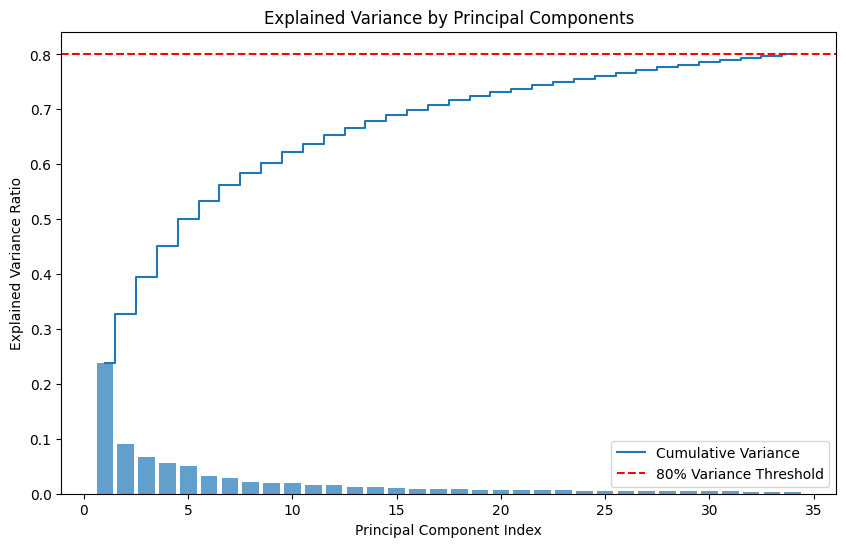

In [1]:
%run preprocessing.ipynb

In [2]:
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Assuming features_train_pca, features_val_pca, features_test_pca, y_train_encoded, y_test_encoded are defined

# Split the training data for validation
train_features, val_features, train_labels, val_labels = train_test_split(
    features_train_pca, y_train_encoded, test_size=0.2, random_state=42, stratify=y_train_encoded
)

# Initialize base models
cat_clf = CatBoostClassifier(
    iterations=3000, learning_rate=0.05, depth=6, l2_leaf_reg=5, border_count=64,
    loss_function='MultiClass', eval_metric='Accuracy', random_seed=42, verbose=100, early_stopping_rounds=100
)
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42)
xgb_clf = XGBClassifier(n_estimators=150, learning_rate=0.05, max_depth=6, random_state=42)

# Train base models
cat_clf.fit(train_features, train_labels, eval_set=(val_features, val_labels), verbose=100)
rf_clf.fit(train_features, train_labels)
xgb_clf.fit(train_features, train_labels)

# Get predictions from base models (using probabilities)
cat_pred_val = cat_clf.predict_proba(val_features)
rf_pred_val = rf_clf.predict_proba(val_features)
xgb_pred_val = xgb_clf.predict_proba(val_features)

# Stack predictions as new features for the meta-model
stacked_features_val = np.hstack((cat_pred_val, rf_pred_val, xgb_pred_val))

# Initialize and train the meta-model
meta_model = LogisticRegression(random_state=42)
meta_model.fit(stacked_features_val, val_labels)

# Get predictions from base models for the test set (using probabilities)
cat_pred_test = cat_clf.predict_proba(features_test_pca)
rf_pred_test = rf_clf.predict_proba(features_test_pca)
xgb_pred_test = xgb_clf.predict_proba(features_test_pca)

# Stack predictions as new features for the meta-model
stacked_features_test = np.hstack((cat_pred_test, rf_pred_test, xgb_pred_test))

# Get final predictions from the meta-model
final_predictions = meta_model.predict(stacked_features_test)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test_encoded, final_predictions)
conf_matrix = confusion_matrix(y_test_encoded, final_predictions)
class_report = classification_report(y_test_encoded, final_predictions)

print(f"Ensemble Model Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

NameError: name 'y_train_encoded' is not defined

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Encode labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_labels)
y_test_encoded = label_encoder.transform(test_labels)

# Train the SVM with RBF kernel
svm_rbf = SVC(kernel='rbf', gamma='scale', random_state=42)  # Changed gamma to 'scale' (recommended default)
svm_rbf.fit(features_train_pca, y_train_encoded)

# Predict and evaluate
y_pred_rbf = svm_rbf.predict(features_test_pca)

# Calculate accuracy
accuracy_rbf = accuracy_score(y_test_encoded, y_pred_rbf)
print('Test Accuracy with RBF Kernel: {:.2f}'.format(accuracy_rbf))

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_rbf)
print('\nConfusion Matrix:')
print(conf_matrix)

# Print the classification report
class_report = classification_report(y_test_encoded, y_pred_rbf, target_names=label_encoder.classes_)
print('\nClassification Report:')
print(class_report)


Test Accuracy with RBF Kernel: 0.79

Confusion Matrix:
[[177  21  14   7]
 [ 11 213   8   5]
 [  7   6 205  44]
 [ 15   7  55 178]]

Classification Report:
              precision    recall  f1-score   support

   buildings       0.84      0.81      0.83       219
      forest       0.86      0.90      0.88       237
    mountain       0.73      0.78      0.75       262
         sea       0.76      0.70      0.73       255

    accuracy                           0.79       973
   macro avg       0.80      0.80      0.80       973
weighted avg       0.79      0.79      0.79       973



In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize CatBoost classifier
cat_clf = CatBoostClassifier(
    iterations=3000,               # Number of boosting rounds
    learning_rate=0.1,            # Lower learning rate for better generalization
    depth=8,                       # Tree depth
    l2_leaf_reg=5,                 # L2 regularization coefficient
    border_count=64,               # Number of splits for numerical features
    loss_function='MultiClass',    # Multiclass classification
    eval_metric='Accuracy',        # Evaluation metric
    random_seed=42,                # For reproducibility
    verbose=100,                   # Output every 100 iterations
    early_stopping_rounds=100       # Early stopping if validation doesn't improve
)

# Split the training data for validation (optional, if no separate val_data)
train_features, val_features, train_labels, val_labels = train_test_split(
    features_train_pca, y_train_encoded, test_size=0.2, random_state=42, stratify=y_train_encoded
)

# Train CatBoost
cat_clf.fit(
    train_features, train_labels,
    eval_set=(val_features, val_labels),
    use_best_model=True  # Automatically select the best iteration based on validation
)

# Predict on test data
y_pred_cat = cat_clf.predict(features_test_pca)

# Evaluate performance
accuracy_cat = accuracy_score(y_test_encoded, y_pred_cat)
print('Test Accuracy with CatBoost: {:.2f}'.format(accuracy_cat))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_cat)
print('\nConfusion Matrix:')
print(conf_matrix)

# Classification report
class_report = classification_report(y_test_encoded, y_pred_cat, target_names=label_encoder.classes_)
print('\nClassification Report:')
print(class_report)




0:	learn: 0.5555556	test: 0.5297297	best: 0.5297297 (0)	total: 27.5ms	remaining: 1m 22s
100:	learn: 0.8095431	test: 0.6697297	best: 0.6713514 (98)	total: 1.64s	remaining: 47.1s
200:	learn: 0.9047040	test: 0.6859459	best: 0.6870270 (196)	total: 2.98s	remaining: 41.5s
300:	learn: 0.9532306	test: 0.6875676	best: 0.6897297 (277)	total: 4.53s	remaining: 40.6s
400:	learn: 0.9794539	test: 0.6956757	best: 0.6989189 (393)	total: 6.08s	remaining: 39.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6989189189
bestIteration = 393

Shrink model to first 394 iterations.
Test Accuracy with CatBoost: 0.76

Confusion Matrix:
[[177  17  18   7]
 [ 19 201  10   7]
 [ 15   6 191  50]
 [ 26   6  53 170]]

Classification Report:
              precision    recall  f1-score   support

   buildings       0.75      0.81      0.78       219
      forest       0.87      0.85      0.86       237
    mountain       0.70      0.73      0.72       262
         sea       0.73      0.67      0.70

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(
    xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1
)
grid_search.fit(features_train_pca, y_train_encoded)

# Get the best model
best_xgb_clf = grid_search.best_estimator_
print('Best Parameters:', grid_search.best_params_)

# Evaluate on test data
y_pred_best = best_xgb_clf.predict(features_test_pca)
accuracy_best = accuracy_score(y_test_encoded, y_pred_best)
print('Test Accuracy with Optimized XGBoost:', accuracy_best)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 